# Real Time Global Inflation Tracker using the OECD API

## Project Goal

This project pulls recent inflation data via the OECD API and explores key trends across countries in the most recent available year that the API offers:
- Median inflation across different countries
- Volatility in inflation (standard deviation)
- Economic outliers and risk zones

## Data Collection and imports

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We pull 2023 inflation data from the OECD API, which provides economic indicators from various countries. To do that, we need to build the API url to get the latest inflation growth rates. This section fetches and decodes the data into a readable format.

In [3]:
# Build the api url
url = "https://stats.oecd.org/SDMX-JSON/data/PRICES_CPI/..GY.CPALTT01.IXOB.R/all?startTime=2023-1&endTime=2023-12"

Create a function to fetch the data. We will use this later.

In [4]:
# Fetch data
def fetch_data_cpi():
  response = requests.get(url)
  if response.status_code != 200:
    raise Exception("Failed to fetch OECD data.")
  return response.json()

json_data = fetch_data_cpi()

## Data Cleaning & Parsing

The OECD data uses composite keys to encode countries and series information. We need to decode those keys and convert the results into a pandas DataFrame: into a format we can easily understand.

In [5]:
def decode_series_key(series_key, series_dims):
  """
  Given a series key and its dimensions e.g. 29:0:0:0:0:8:0:0. decode each part into a
  dictionary mapping each dimension into a human-readable name.
  """
  indices = series_key.split(":")
  decoded = {}
  for i, idx in enumerate(indices):
      position = int(idx);
      dim_def = series_dims[i];
      # Each dimension's values is a list of dictionaries containing an
      # 'id' and a 'name' (the human-readable label)
      decoded[dim_def["id"]] = dim_def["values"][position]["name"]

  return decoded

The API request returns a nested format (SDMX-JSON). We need to unpack so that we can convert it to a DataFrame.

In [6]:
def parse_oecd_cpi(json_data):
  structures = json_data["data"]["structures"]

  # First structure object contains our dimensions
  structure = structures[0]
  series_dims = structure["dimensions"]["series"]

  # Get the dataset
  dataSets = json_data["data"]["dataSets"]

  # The series object holds all the observations keyed by composite keys
  series_data = dataSets[0].get("series", {})

  records = []
  for key, info in series_data.items():
    # Decode the composite key into dimension values
    decoded = decode_series_key(key, series_dims)

    # Determine the country
    country = decoded.get("LOCATION")
    if not country:
      country = list(decoded.values())[0]

    # For each observations/records in the series get the inflation value
    observations = info.get("observations", {})
    for obs_index, obs_value in observations.items():
      # The first element in the obs_value list is the inflation rate
      inflation = obs_value[0]
      records.append({
          "Country": country,
          "ObservationIndex": obs_index,
          "Inflation (%)": inflation,
      })

  return pd.DataFrame(records)

Now fetch and parse the data. Then decode the composite keys. Then, show the resulting dataframe.

In [7]:
# Fetch the json data
json_data = fetch_data_cpi();

# Print top-level keys to confirm structure
print("Top-level keys: ", list(json_data.keys()))

# Parse the data and decode the composite keys
df_inflation = parse_oecd_cpi(json_data)

# Show the resulting DataFrame
print(df_inflation.head())

Top-level keys:  ['meta', 'data', 'errors']
  Country ObservationIndex  Inflation (%)
0   Chile                0     -17.540040
1   Chile                1     -11.307720
2   Chile                2      -7.026299
3   Chile                3     -11.998990
4   Chile                4      -5.931939


In [8]:
df_inflation.tail()

,Country,ObservationIndex,Inflation (%)
2699768,Romania,10,4.8
2699769,Romania,11,2.8
2699770,Romania,12,16.4
2699771,Romania,13,14.6
2699772,Romania,930,2.9


As we can see from the output, it is multiple records of a country with different inflation rates, indicating many different reports. We need to group by country and find the average by country and use that to make visualizations.

In [17]:
# Group by 'country' and calculate the mean for 'Inflation (%)'
median_inflation = df_inflation.groupby('Country')['Inflation (%)'].median().reset_index()

Sort by average inflation by descending order for it to be easier to see.

In [18]:
# Sort by average inflation
median_inflation = median_inflation.sort_values(by='Inflation (%)', ascending=False)

# Display the resulting DataFrame
median_inflation.head()

,Country,Inflation (%)
0,Argentina,22.647240
52,Türkiye,9.117008
10,Costa Rica,7.473261
44,Russia,7.166016
43,Romania,6.600000


Now we have gotten the data, time to analyze it!

## Data Analysis

## Which countries had the highest and lowest inflation rates in 2023?

This is important since it shows how consistently prices increased or decreased, revealing both stability and cost of living pressures. This can indicate whether a country would have a higher purchasing power or not.

We would like to know the top 10 countries with the highest median inflation rate in the year 2023. Let's answer this by using a visualization.

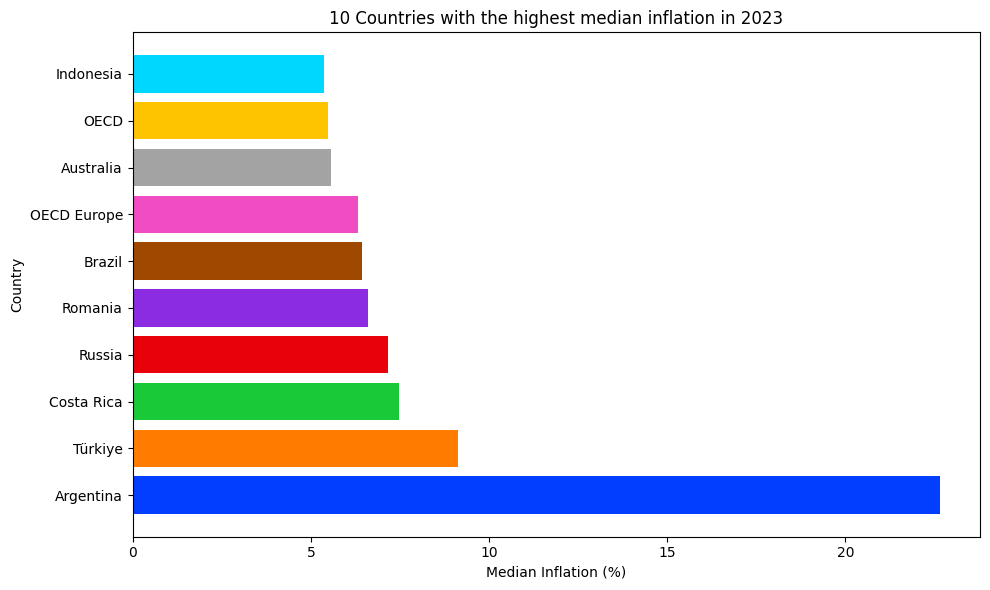

In [27]:
# Get the top 10 countries and their median inflation values
countries = median_inflation['Country'].head(10)
inflation = median_inflation['Inflation (%)'].head(10)

# Create a color palette as many colours as there are countries just to make it more appealing
colors = sns.color_palette('bright', len(countries))

plt.figure(figsize=(10, 6))
plt.barh(countries, inflation, color=colors)
plt.xlabel('Median Inflation (%)')
plt.ylabel('Country')
plt.title('10 Countries with the highest median inflation in 2023')
plt.tight_layout()
plt.show()

Next, we would like to know the 10 countries with the lowest median inflation rates. Let's show them by use of a visualization.

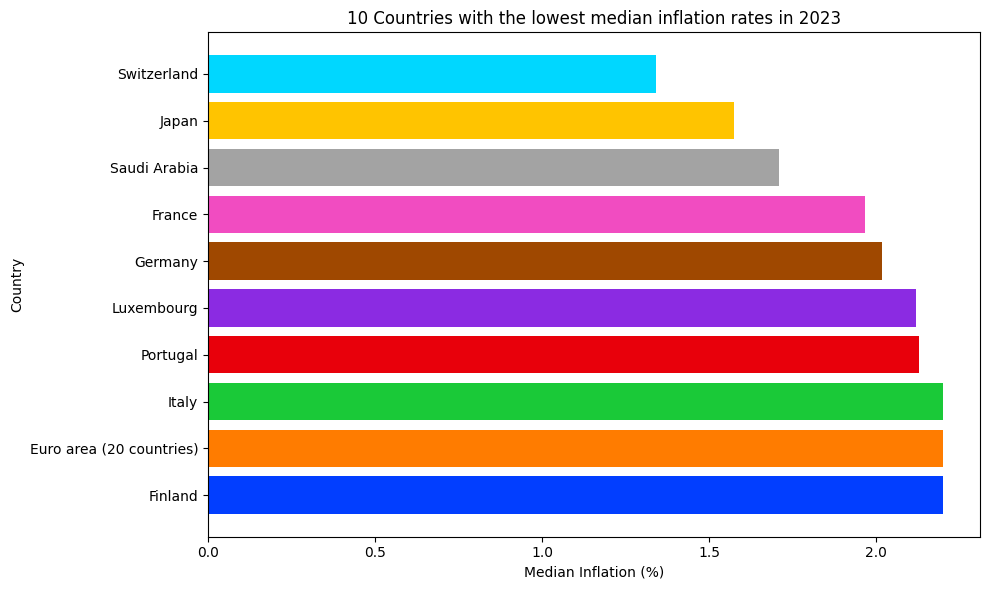

In [26]:
# Get the bottom 10 countries and their median inflation values
countries = median_inflation['Country'].tail(10)
inflation = median_inflation['Inflation (%)'].tail(10)

# Create a color palette as many colours as there are countries just to make it more appealing
colors = sns.color_palette('bright', len(countries))

plt.figure(figsize=(10, 6))
plt.barh(countries, inflation, color=colors)
plt.xlabel('Median Inflation (%)')
plt.ylabel('Country')
plt.title('10 Countries with the lowest median inflation rates in 2023')
plt.tight_layout()
plt.show()

From the above visualizations, we now know the countries with the highest and lowest inflation rates from the data that we pulled from the OECD API.

## Which countries had the most unstable or stable inflation?

High volatility in countries signals an unpredictable economy. Without stability, it disrupts planning, raises costs, and kills investment, making it difficult for businesses to grow, thrive and survive.

We would like to know the countries with the most and least volatile inflation rates (the ones that changed alot). Let's derive this from our data using standard deviation.

<ipython-input-30-5613ca0c5b88>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_volatility, y='Country', x='Inflation Volatility (%)', palette='magma')


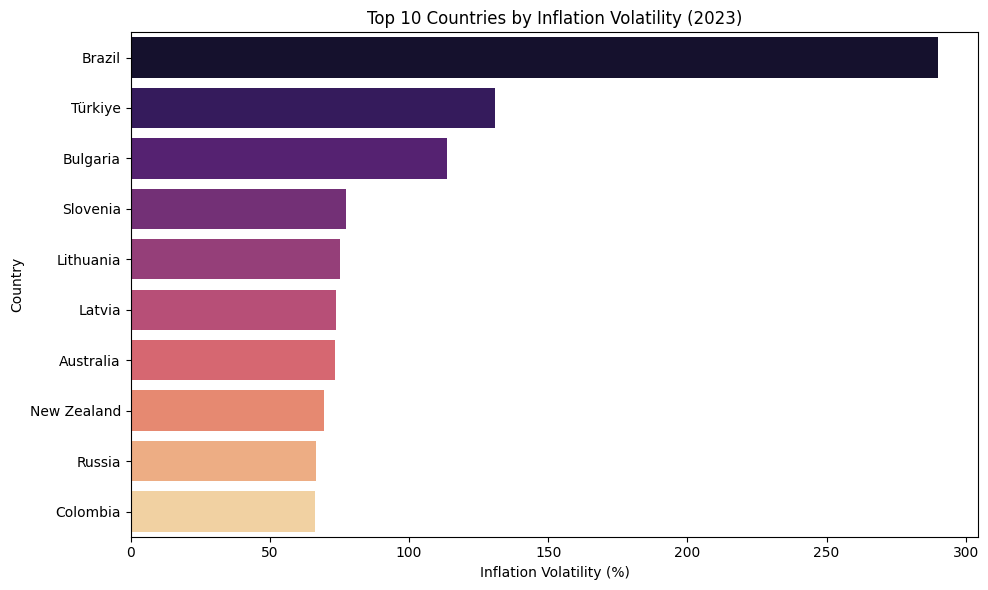

In [30]:
volatility = df_inflation.groupby('Country')['Inflation (%)'].std().reset_index()
volatility.columns = ['Country', 'Inflation Volatility (%)']
volatility_sorted = volatility.sort_values(by='Inflation Volatility (%)', ascending=False)

top_10_volatility = volatility_sorted.head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_volatility, y='Country', x='Inflation Volatility (%)', palette='magma')
plt.title('Top 10 Countries by Inflation Volatility (2023)')
plt.xlabel('Inflation Volatility (%)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

<ipython-input-29-a925509211b5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom_10_volatility, y='Country', x='Inflation Volatility (%)', palette='magma')


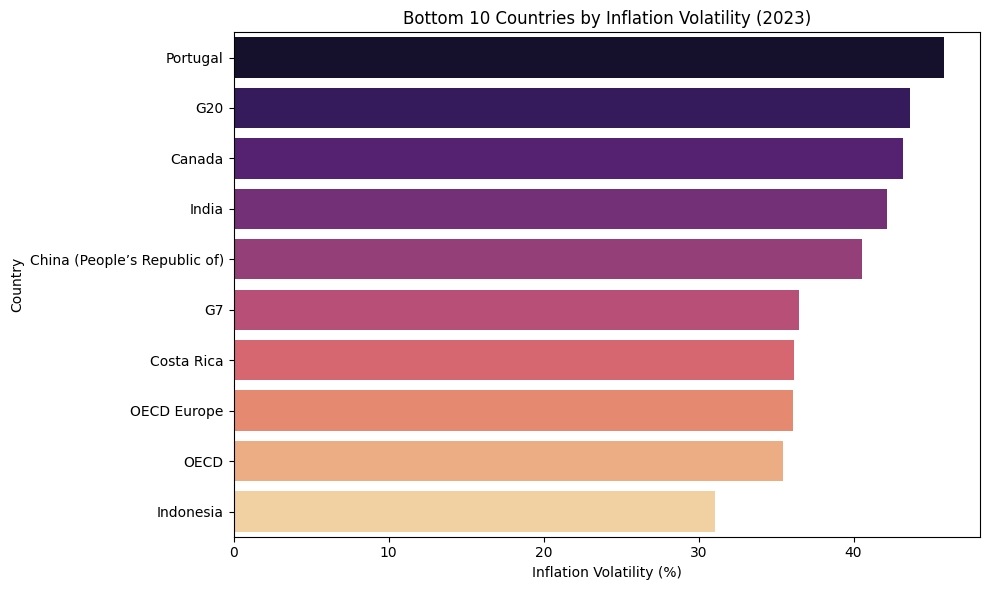

In [29]:
bottom_10_volatility = volatility_sorted.tail(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=bottom_10_volatility, y='Country', x='Inflation Volatility (%)', palette='magma')
plt.title('Bottom 10 Countries by Inflation Volatility (2023)')
plt.xlabel('Inflation Volatility (%)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

### Can we spot "outliers" ? Essentially, countries with both high inflation and high volatilities?

These outliers represent economies under pressure or transitioning and deserve deeper attention.

Lastly, let's create a scatterplot that merges the two!

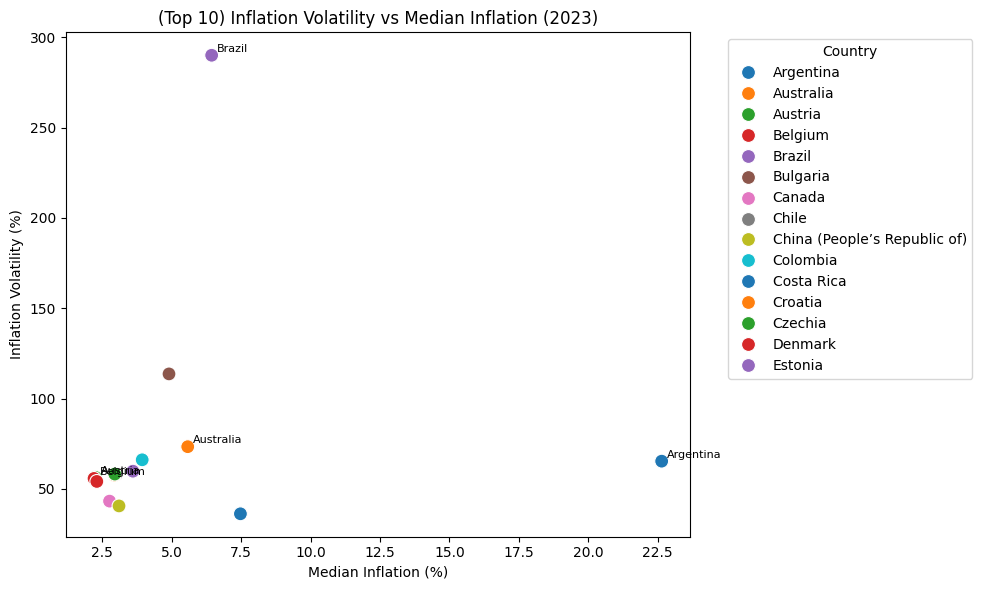

In [41]:
# Calculate Median Inflation per Country
median_inflation = df_inflation.groupby('Country')['Inflation (%)'].median().reset_index()
median_inflation.columns = ['Country', 'Median Inflation (%)']

# Calculate Volatility (Standard Deviation) per Country
volatility = df_inflation.groupby('Country')['Inflation (%)'].std().reset_index()
volatility.columns = ['Country', 'Inflation Volatility (%)']

# Merge both into a single DataFrame. Just get the top 15 most volatile
inflation_stats = pd.merge(median_inflation, volatility, on='Country').head(15)

# Plot the Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=inflation_stats,
    x='Median Inflation (%)',
    y='Inflation Volatility (%)',
    hue='Country',
    s=100,
    palette='tab10'
)

for _, row in inflation_stats.head(5).iterrows():
    plt.text(
        row['Median Inflation (%)'] + 0.2,
        row['Inflation Volatility (%)'] + 2,
        row['Country'],
        fontsize=8,
        color='black'
    )

plt.title('(Top 10) Inflation Volatility vs Median Inflation (2023)')
plt.xlabel('Median Inflation (%)')
plt.ylabel('Inflation Volatility (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Country')
plt.tight_layout()
plt.show()

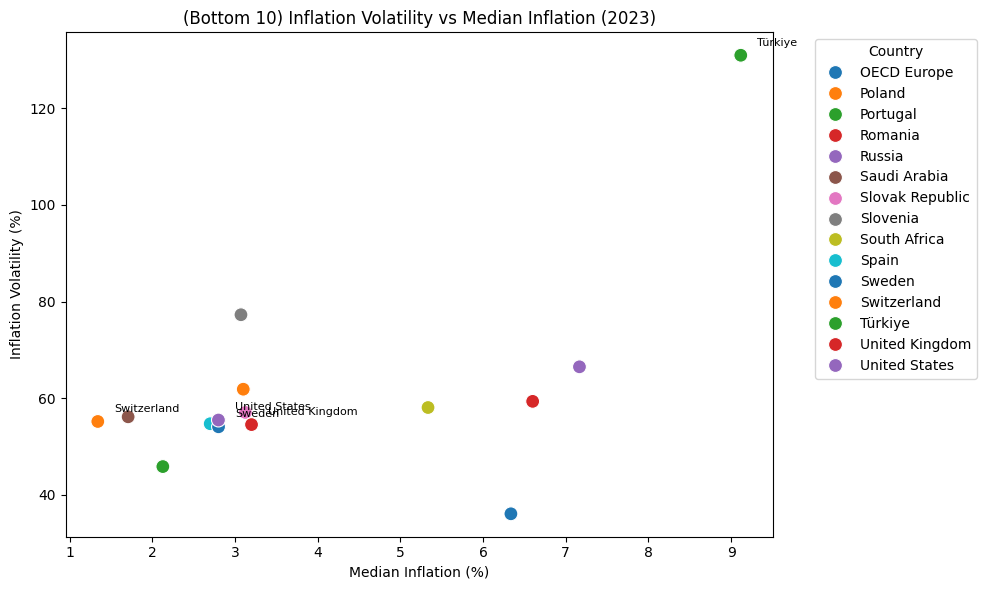

In [40]:
# Merge both into a single DataFrame. Just get the top 15 most volatile
inflation_stats = pd.merge(median_inflation, volatility, on='Country').tail(15)

# Plot the Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=inflation_stats,
    x='Median Inflation (%)',
    y='Inflation Volatility (%)',
    hue='Country',
    s=100,
    palette='tab10'
)

for _, row in inflation_stats.tail(5).iterrows():
    plt.text(
        row['Median Inflation (%)'] + 0.2,
        row['Inflation Volatility (%)'] + 2,
        row['Country'],
        fontsize=8,
        color='black'
    )

plt.title('(Bottom 10) Inflation Volatility vs Median Inflation (2023)')
plt.xlabel('Median Inflation (%)')
plt.ylabel('Inflation Volatility (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Country')
plt.tight_layout()
plt.show()

## Insights and Key Takeaways


From the data, we can see that:
- The 3 countries with the highest inflation rates are: Argentina, Costa Rica, Turkey. This show strong indicators of ongoing economic strain. Which is bad for business.
- The 3 areas with the lowest inflation rates are: The Euro Area, Finland, Italy. This indicates relative price stability. Possibly strong purchasing power.
- The 3 countries with the highest volatility rates are: Brazil, Turkey, Bulgaria. This shows that inflation trends are unpredictable and is risky for long-term business planning.
- The 3 areas with the lowest volatility rates are: Potrugal, G20, Canada. This shows that they have very stable inflation, ideal conditions for investors and policy makers.
- The evident outliers are Argentina and Brazil. This shows that they experience both high inflation and high volatility. Very bad for businesses. Businesses should avoid the two.